In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
# create helper function to load the data from jsonl files
def load_jsonl(file_path: str) -> list[dict]:
    """
    Load a jsonl file and return a list of dictionaries.
    """
    data = []
    with open(file_path, "r") as f:
        for line in f:
            item = json.loads(line)
            # keep only the "conversation" and "target_agent" fields
            item = {
                "conversation": item["conversation"],
                "target_agent": item["target_agent"]
            }
            data.append(item)
    return data
    

In [4]:
# load the training and testing data
train_dataset = load_jsonl("../data_sets/triage-training-proofread.jsonl")
test_dataset = load_jsonl("../data_sets/triage-testing.jsonl")

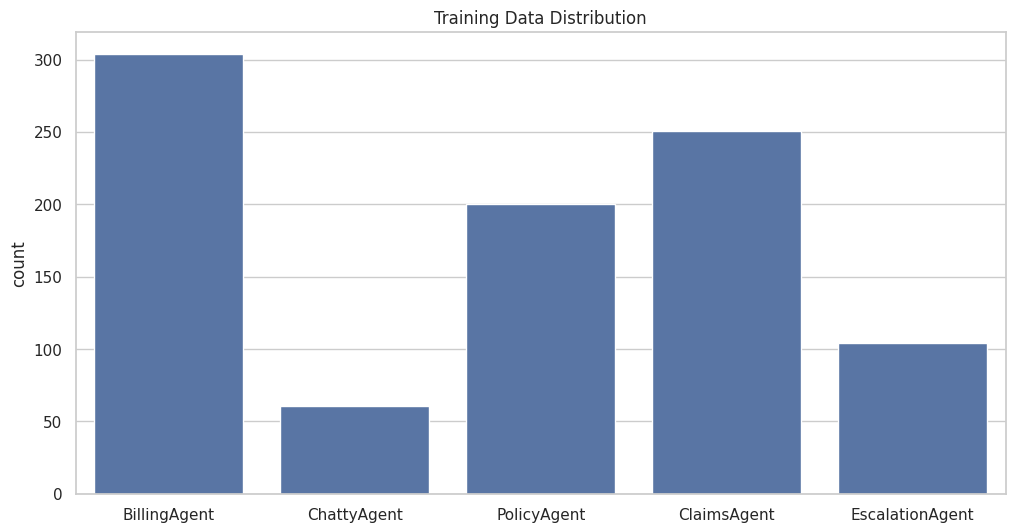

In [21]:
# plot training data distribution
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x=[item["target_agent"] for item in train_dataset])
plt.title("Training Data Distribution")
plt.show()
# save the plot
# plt.savefig("training_data_distribution.png", bbox_inches="tight")

### Training data distribution is unbalance, with the `ChattyAgent` and `EscalationAgent` being slightly underrepresented.

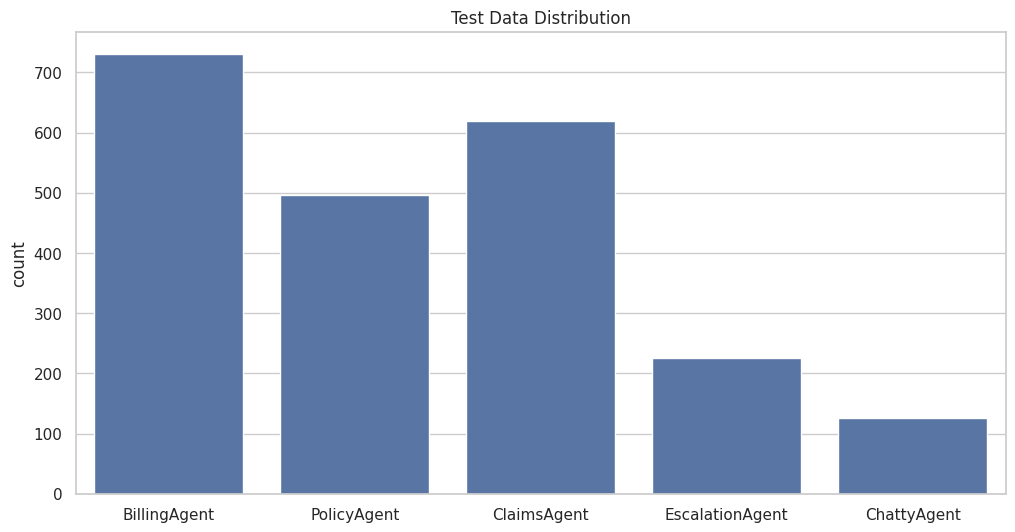

In [23]:
# plot test data distribution
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x=[item["target_agent"] for item in test_dataset])
plt.title("Test Data Distribution")
plt.show()
# save the plot
# plt.savefig("test_data_distribution.png", bbox_inches="tight")

### Categories in the test data are distribute similarly to the training data, with the `ChattyAgent` and `EscalationAgent` being slightly underrepresented.

# Message embeddings visualization

Let's use the SentenceTransformer model [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084) in order to compute the embeddings of the training conversations. We will use the `all-MiniLM-L12-v2` model, which is a smaller and faster version of the original BERT model. This model is trained on a large corpus of data and is able to produce high-quality sentence embeddings.

In [7]:
# compute embeddings of the training instructions
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L12-v2")
train_embeddings = model.encode([item["conversation"] for item in train_dataset])

/home/adrian/workspace/EggAI/examples/multi_agent_human_chat/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
print(train_embeddings.shape)

(920, 384)


In [9]:
# compute embeddings of the test instructions
test_embeddings = model.encode([item["conversation"] for item in test_dataset])

In [10]:
print(test_embeddings.shape)

(2197, 384)


### Let's visualize the embeddings of the training set instructions using t-SNE.

In [11]:
# compute tsne of the training embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_embeddings)

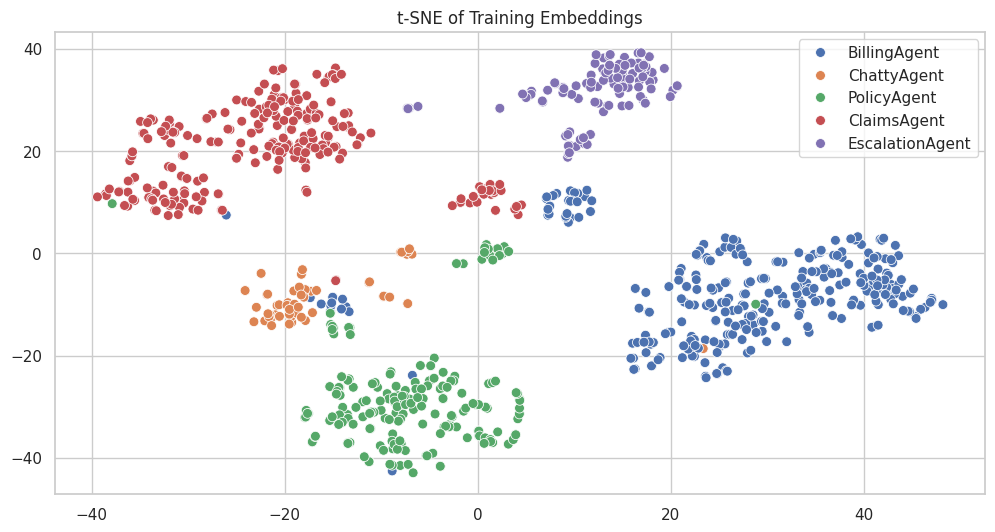

In [24]:
# plot tsne of the training embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train_tsne[:, 0], y=train_tsne[:, 1], hue=[item["target_agent"] for item in train_dataset], s=50)
plt.title("t-SNE of Training Embeddings")
# save the plot
# plt.savefig("train_tsne.png", bbox_inches="tight")

### Interpretation of the t-SNE plot 
We can see that the embeddings of the training set instructions are well separated, with the `BillingAgent` and `ChattyAgent` being slightly overlapping. This problem should be easily solvable using a simple linear classifier based on the Sentence-Transformer embeddings.

In [18]:
# compute tsne of the test embeddings   
test_tsne = tsne.fit_transform(test_embeddings)

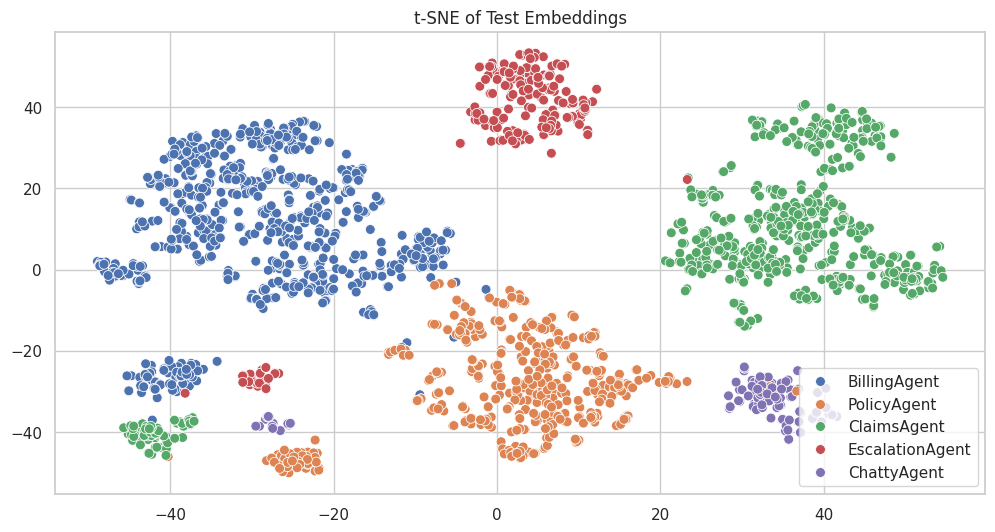

In [25]:
# plot tsne of the test embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(x=test_tsne[:, 0], y=test_tsne[:, 1], hue=[item["target_agent"] for item in test_dataset], s=50)
plt.title("t-SNE of Test Embeddings")
# save the plot
# plt.savefig("test_tsne.png", bbox_inches="tight")

### Interpretation of the t-SNE plot
Test set seems to be much easier to classify, since hardly any points overlap. 